In [120]:
import numpy as np

In [121]:
X_train_basic = np.load("../data/X_train_basic.npy")
X_train_freq = np.load("../data/X_train_freq.npy")
X_train_ite = np.load("../data/X_train_ite.npy")
y_train = np.load("../data/y_train.npy")
X_test_basic = np.load("../data/X_test_basic.npy")
X_test_freq = np.load("../data/X_test_freq.npy")
X_test_ite = np.load("../data/X_test_ite.npy")
y_test = np.load("../data/y_test.npy")

# Performance Metrics

In [122]:
import matplotlib.pyplot as plt
# cosmetic options for matplotlib
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlepad"] = 10.0
plt.rcParams["axes.titlelocation"] = "left"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg")
import seaborn as sns

In [123]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

## Confusion Matrix

The function `cross_val_predict` returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. It is not appropriate for measuring generalisation error but suited for comparing different models.

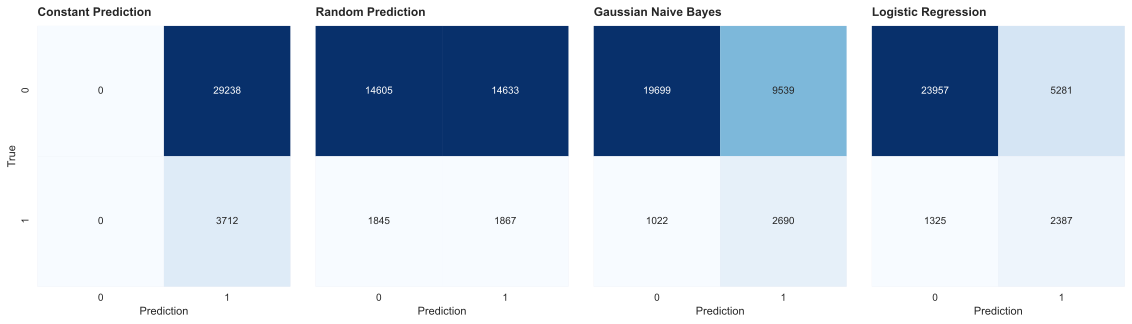

In [124]:
names = ["Constant Prediction", "Random Prediction", "Gaussian Naive Bayes", "Logistic Regression"]
clfs = [DummyClassifier(strategy="constant", constant=1),
        DummyClassifier(strategy="uniform"),
        GaussianNB(),
        LogisticRegression(class_weight="balanced")]
f, axs = plt.subplots(1, 4, figsize=(4.8*4+0.1*3, 4.8), sharey=True, gridspec_kw=dict(wspace=0.1, width_ratios=[1, 1, 1, 1]))
for i, name, clf in zip([0,1,2,3], names, clfs):
    conf_mat = confusion_matrix(y_train, cross_val_predict(clf, X_train_freq, y_train, cv=10, n_jobs=-1))
    conf_ax = sns.heatmap(conf_mat, 
                              ax=axs[i], 
                              annot=True, 
                              fmt="", 
                              cmap=plt.cm.Blues, 
                              cbar=False)
    conf_ax.set_xlabel('Prediction')
    if i == 0:
        conf_ax.set_ylabel('True')
    conf_ax.set_title(name)

## Performance Matrics

From the Confusion Matrix, we can deride some key performance metrics.

The false positive rate (FPR) measures the error rate of the negative outcomes:

$$
FPR = \frac{FP}{FP+TN}
$$

The true positive rate (TPR) measures the accuracy rate for the positive outcomes. True positive rate is also known as recall (REC):

$$
REC = TPR = \frac{TP}{TP+FN}
$$

Precision (PRE) measures the accuracy of the predicted positive outcomes:

$$
PRE = TPR = \frac{TP}{TP+FP}
$$

To balance the up- and down-sides of optimizing PRE and REC, the harmonic mean of precision and recall is used:

$$
F_1 = 2 \cdot \frac{PRE \times REC}{PRE + REC}
$$

Balanced accuracy normalizes true positive rate and true negative rate and divides their sum by two:

$$
bACC = \frac{TPR+TNR}{2}
$$


In [109]:
y_pred = cross_val_predict(GaussianNB(), X_train_freq, y_train, cv=10, n_jobs=-1)
pre = precision_score(y_train, y_pred)
rec = recall_score(y_train, y_pred)
roc = roc_auc_score(y_train, y_pred)
print(pre, rec, roc)

0.21996892632267562 0.724676724137931 0.699211609213093


In [110]:
from sklearn.metrics import precision_recall_curve

0.31129368805425145 0.6430495689655172 0.7312142297252513


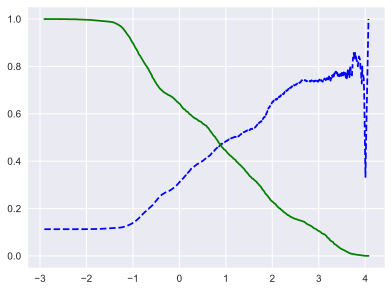

In [111]:
y_pred = cross_val_predict(LogisticRegression(class_weight="balanced"), X_train_freq, y_train, cv=10, n_jobs=-1)
pre = precision_score(y_train, y_pred)
rec = recall_score(y_train, y_pred)
roc = roc_auc_score(y_train, y_pred)
print(pre, rec, roc)
y_scores = cross_val_predict(LogisticRegression(class_weight="balanced"), X_train_freq, y_train, cv=10,n_jobs=-1, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.show()

In [117]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

Text(0.0, 1.0, '2-class Precision-Recall curve: AP=0.46')

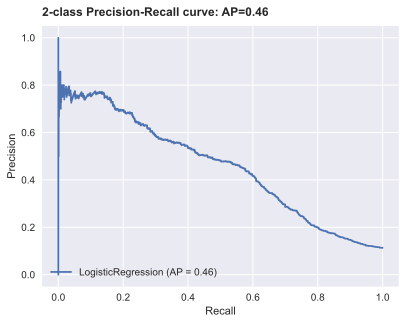

In [119]:
lr_clf = LogisticRegression(class_weight="balanced").fit(X_train_freq, y_train)
y_score = lr_clf.decision_function(X_test_freq)
average_precision = average_precision_score(y_test, y_score)
disp = plot_precision_recall_curve(lr_clf, X_test_freq, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [112]:
from sklearn.metrics import roc_curve

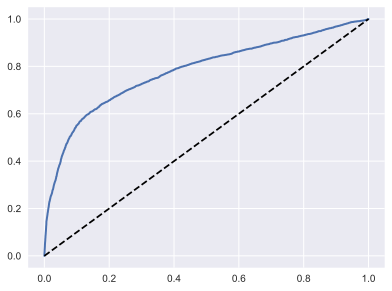

In [113]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

In [86]:
names = ["Constant Prediction", "Random Prediction", "Gaussian Naive Bayes"]
clfs = [DummyClassifier(strategy="constant", constant=1),
        DummyClassifier(strategy="uniform"),
        GaussianNB()]
scoring = ["f1", "precision", "recall", "roc_auc"]

In [88]:
# Initialize Model
# nb_model = GaussianNB()
# logit_model = LogisticRegression(class_weight="balanced")
# knn_model = KNeighborsClassifier(n_neighbors=5)
# Train model and get CV results 
# nb_cv = cross_validate(nb_model, X_train, y_train, scoring=scoring, cv = 5)
# logit_cv = cross_validate(logit_model, X_train, y_train, scoring=scoring, cv = 5)
# knn_cv = cross_validate(knn_model, X_train, y_train, scoring=scoring, cv = 5)
# Calculate CV result mean
# nb_result = pd.DataFrame(nb_cv).mean().rename("Naive Bayes")
# logit_result = pd.DataFrame(logit_cv).mean().rename("Logistic Regression")
# knn_result = pd.DataFrame(knn_cv).mean().rename("KNN")
# Store and output result
# result = pd.concat([nb_result, logit_result, knn_result], axis=1)
# result

In [89]:
# Initialize and fit Model
# nb_model = GaussianNB().fit(X_train, y_train)
# logit_model = LogisticRegression(class_weight="balanced").fit(X_train, y_train)
# knn_model = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
# Predict and calculate score
# dummy_predict = dummy_model.predict(X_test)
# dummy_f1 = f1_score(y_test, dummy_predict)
# dummy_precision = precision_score(y_test, dummy_predict)
# dummy_recall = recall_score(y_test, dummy_predict)
# dummy_roc_auc = roc_auc_score(y_test, dummy_predict)
# nb_predict = nb_model.predict(X_test)
# nb_f1 = f1_score(y_test, nb_predict)
# nb_precision = precision_score(y_test, nb_predict)
# nb_recall = recall_score(y_test, nb_predict)
# nb_roc_auc = roc_auc_score(y_test, nb_predict)
# logit_predict = logit_model.predict(X_test)
# logit_f1 = f1_score(y_test, logit_predict)
# logit_precision = precision_score(y_test, logit_predict)
# logit_recall = recall_score(y_test, logit_predict)
# logit_roc_auc = roc_auc_score(y_test, logit_predict)
# knn_predict = knn_model.predict(X_test)
# knn_f1 = f1_score(y_test, knn_predict)
# knn_precision = precision_score(y_test, knn_predict)
# knn_recall = recall_score(y_test, knn_predict)
# knn_roc_auc = roc_auc_score(y_test, knn_predict)
# Store and output result
# result = pd.DataFrame(data={"Dummy Classifier": [dummy_f1, dummy_precision, dummy_recall, dummy_roc_auc],
#                             "Naive Bayes": [nb_f1, nb_precision, nb_recall, nb_roc_auc],
#                             "Logistic Regression": [logit_f1, logit_precision, logit_recall, logit_roc_auc],
#                             "KNN": [knn_f1, knn_precision, knn_recall, knn_roc_auc]},
#                        index=["F1 Score", "Precision Score", "Recall Score", "ROC AUC Score"])
# result